In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # for fancy interactive plot
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import os # to check if directory exists and create it if it doesn't
from datetime import datetime # to parse speech date
from nrclex import NRCLex
import spacy
import en_core_web_md
import csv
import prince # for correspondence analysis
import nltk
from scipy.stats import power_divergence # for g-test (log likelihood ratio)
from scipy.stats.contingency import association
from scipy.stats import chi2_contingency
from scipy.stats import chi2
stopwords = pd.read_table('./word_lists/kaggle_stopwords.txt')

In [15]:
#cont_table = pd.read_csv('ContingencyTable.csv', index_col=0)
cont_table = pd.read_csv('obamaContingencyTable_noSW.csv', index_col=0)
cont_table = cont_table.astype(int)
ctab_gwb = pd.read_csv('GWB_ContingencyTable_noSW.csv', index_col=0)
ctab_gwb = ctab_gwb.astype(int)

<A HREF="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.power_divergence.html">SciPy power divergence for G-test or log-likelihood ratio</A> set lambda_='log-likelihood' for g-test

In [16]:
g_test = power_divergence(cont_table, lambda_='log-likelihood')

/home/muddy/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7410: RuntimeWarning: invalid value encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)


<A HREF="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html#scipy.stats.contingency.association">SciPy association</A>

In [17]:
# Problems with no stopwords version of Obama contingency table ..... arghhh
# Association: A value of 1.0 indicates perfect association, and 0.0 means the variables have no association
association(cont_table, method="cramer")

ValueError: The internally computed table of expected frequencies has a zero element at (0, 6656).

In [18]:
#cont_table.iloc[0:5, 11875:]

In [19]:
len(g_test[0])

8037

<A HREF="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html">SciPy contingency table Chi2 test</A>

from <A HREF="https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test">Wikipedia</A> : In cases where the expected value, E, is found to be small (indicating a small underlying population probability, and/or a small number of observations), the normal approximation of the multinomial distribution can fail, and in such cases it is found to be more appropriate to use the G-test, a likelihood ratio-based test statistic

In [20]:
# Problems with no stopwords version of Obama contingency table ..... arghhh
# H0: observed frequencies are independent
res_chi2 = chi2_contingency(cont_table)
print("Statistic:",res_chi2[0],"\tp-value:",res_chi2[1],"\tdf:",res_chi2[2])
# pval<0.001 reject H0, there is a difference in counts of words between the various speeches

ValueError: The internally computed table of expected frequencies has a zero element at (0, 6656).

In [21]:
chi2.stats(res_chi2[2])

(1178397.0, 2356794.0)

Starting with <A HREF="https://aclanthology.org/J93-1003/">Dunning 1993</A> the g-test (likelihood ratio) became popular for computational linguistics

In [22]:
# Problems with no stopwords version of Obama contingency table ..... arghhh
res_gtest = chi2_contingency(cont_table, lambda_="log-likelihood") # g-test
print("Statistic:",res_gtest[0],"\tp-value:",res_gtest[1],"\tdf:",res_gtest[2])

ValueError: The internally computed table of expected frequencies has a zero element at (0, 6656).

In [40]:
col_sums = np.reshape(cont_table.sum(axis=0).to_numpy(), (-1,1))
row_sums = np.reshape(cont_table.sum(axis=1).to_numpy(), (-1,1))
total = row_sums.sum()

In [41]:
expected = pd.DataFrame(np.matmul(row_sums, np.transpose(col_sums))/total, columns=cont_table.columns, index=cont_table.index)

### Compare words which occur more than expected - Obama vs. Bush

In [42]:
# Obama Words occuring more often than expected
difference = cont_table.subtract(expected)
difference.mean(axis=0).sort_values(ascending=False).head(20)

american    1.421085e-16
           1.065814e-16
job         1.065814e-16
people      8.881784e-17
world       8.881784e-17
support     7.993606e-17
end         7.105427e-17
want        7.105427e-17
help        7.105427e-17
ll         6.772360e-17
past        6.217249e-17
partner     5.995204e-17
national    5.995204e-17
tonight     5.551115e-17
plan        5.329071e-17
law         5.329071e-17
privacy     4.940492e-17
bank        4.884981e-17
woman       4.884981e-17
come        4.884981e-17
dtype: float64

In [37]:
col_sums_gwb = np.reshape(ctab_gwb.sum(axis=0).to_numpy(), (-1,1))
row_sums_gwb = np.reshape(ctab_gwb.sum(axis=1).to_numpy(), (-1,1))
total_gwb = row_sums_gwb.sum()
expected_gwb = pd.DataFrame(np.matmul(row_sums_gwb, np.transpose(col_sums_gwb))/total, 
                        columns=ctab_gwb.columns, index=ctab_gwb.index)
difference_gwb = ctab_gwb.subtract(expected_gwb)
# GWB Words occuring more often than expected
difference_gwb.mean(axis=0).sort_values(ascending=False).head(20)

company        1.578984e-16
child          1.134895e-16
ve             1.134895e-16
nuclear        9.868649e-17
nation         8.635068e-17
time           8.388352e-17
great          8.388352e-17
year           7.648203e-17
state          6.908054e-17
new            6.908054e-17
palestinian    6.537980e-17
cuban          6.075387e-17
terror         5.921189e-17
american       5.921189e-17
threat         5.181041e-17
plot           4.996004e-17
require        4.934325e-17
day            4.687608e-17
parent         4.625929e-17
health         4.317534e-17
dtype: float64

### Date of speech of interest

In [26]:
# Sort words from one speech by difference between observed and expected
date = '2011-09-09'
# Words occuring more often than expected - over represented
difference[difference.index.str.startswith(date)].iloc[0].sort_values(ascending=False)[0:20]

job         25.733894
tax         20.646703
right       16.518326
company     14.175893
business    13.443605
plan        13.385226
cut         13.156433
pass        12.614019
build        9.718307
away         9.463820
worker       8.633478
economy      8.263839
hire         8.035802
pay          7.930758
ask          7.091064
idea         7.038919
small        6.793784
proposal     6.378991
work         5.945589
meet         5.649821
Name: 2011-09-09-SpeechJobsAct, dtype: float64

In [43]:
# Words occuring less often than expected
difference[difference.index.str.startswith(date)].iloc[0].sort_values(ascending=False)[-20:]

ago       -2.631117
student   -2.631117
end       -2.644342
child     -2.788305
effort    -2.873134
force     -2.925279
nuclear   -2.941621
stand     -3.003873
day       -3.017098
war       -3.036558
energy    -3.415549
think     -3.445116
come      -3.498016
's        -3.644342
change    -3.915927
like      -4.566503
say       -5.337710
today     -6.108917
ve        -6.112035
'         -6.177404
Name: 2011-09-09-SpeechJobsAct, dtype: float64

In [47]:
# LOAD CONTINGENCY TABLE
# Read in saved contingency table
ctab = pd.read_csv('obamaContingencyTable_noSW.csv',index_col=0) 
# Shorten row index names to date only
ctab = ctab.rename(index = lambda x: x[0:10])
ca = prince.CA(n_components=2,
               n_iter=3,copy=True,
               check_input=True,
               engine='sklearn',
               random_state=33)

In [48]:
%matplotlib notebook

### Ok, let's cram this into one cell. Enter data of interest at top... out pops a nice CA plot

<IPython.core.display.Javascript object>


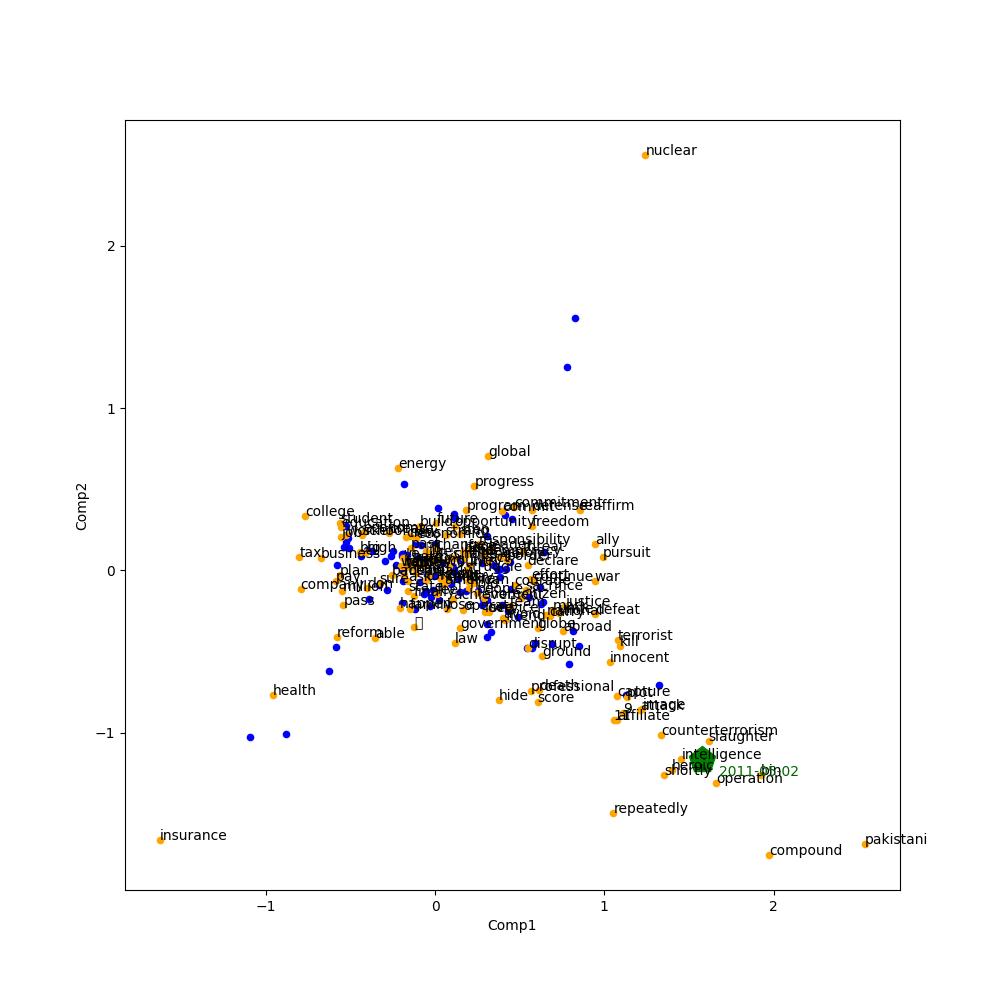

In [49]:
# 2011-07-26 debt ceiling
# 2011-05-02 Osama bin Laden killed
# 2011-09-09 Speech Jobs Act
# 2011-06-23 Afghanistan Pullout
# 2011-05-23 Missouri Tornado

# Sort words from one speech by difference between observed and expected
date = '2011-05-02'
# label location adjustment
x=0.1
y=-0.1
#make word list from difference between observed and expected
over_rep = difference[difference.index.str.startswith(date)].iloc[0].sort_values(ascending=False)[0:75]
under_rep = difference[difference.index.str.startswith(date)].iloc[0].sort_values(ascending=False)[-75:]
over_rep = pd.DataFrame(over_rep)
under_rep = pd.DataFrame(under_rep)

word_list = pd.concat([over_rep, under_rep])
word_list.columns = ['difference']
word_list['word']=word_list.index
word_list.drop(word_list.loc[word_list['word']=='â'].index, inplace=True) # get rid of that pesky goofy a
# Make a short contingency list using topic words
ctabshort = ctab.loc[ : , [col for col in ctab.columns if col in list(word_list['word'])]]
ctabshort.dropna(inplace=True)
# Keep it to the most common 150 words
if np.shape(ctabshort)[1] > 150:
    ctabshort=ctabshort.iloc[:, : 150]
    
ctabshort.columns.rename('words', inplace=True)
ctabshort.index.rename('speeches', inplace=True)
# Fit Correspondence Analysis with speeches and specified word list
ca = ca.fit(ctabshort)

date1 = '2011-05-02'     # date1 - red X   --- uncomment ax.plot line 46 to highlight two points
date2 = date             # date2 - green pentagon 
df1=ca.row_coordinates(ctabshort)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
#Label speech points
#for i, txt in enumerate(df1.index.values.tolist()):
#    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

#ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
#ax.annotate(date1, (df1['Comp1'][date1]+0.1, df1['Comp2'][date1]), color='darkred')
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)
ax.annotate(date2, (df1['Comp1'][date2]+x, df1['Comp2'][date2]+y), color='darkgreen')

#plt.xlim([-0.25, 5.0])
#plt.ylim([-1.2, 1.0])
plt.show()